In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import Statsmodels
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

Let's test the VAR model with monthly data.

Import the data (I'll first try with monthly data).

In [89]:
dvar = pd.read_csv("../Data/monthly_data.csv")

In [90]:
dvar = dvar.dropna()
dvar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94 entries, 1 to 94
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   datetime                 94 non-null     object 
 1   suction_tension (20cm)   94 non-null     float64
 2   suction_tension (40cm)   94 non-null     float64
 3   suction_tension (70cm)   94 non-null     float64
 4   water_temperature        94 non-null     float64
 5   barometric_pressure_qfe  94 non-null     float64
 6   dew_point                94 non-null     float64
 7   water_level              94 non-null     float64
 8   inflow_linth (m3/s)      94 non-null     float64
 9   outflow_limmat (m3/s)    94 non-null     float64
 10  precipitation (mm)       94 non-null     float64
 11  Evapotranspiration (mm)  94 non-null     float64
 12  change_rate              94 non-null     float64
dtypes: float64(12), object(1)
memory usage: 10.3+ KB


In [91]:
# convert DateTime column into datetime format
dvar["datetime"] = pd.to_datetime(dvar['datetime'])
# set DateTime as index
dvar.set_index("datetime", inplace=True)
dvar.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 94 entries, 2012-02-29 to 2019-11-30
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   suction_tension (20cm)   94 non-null     float64
 1   suction_tension (40cm)   94 non-null     float64
 2   suction_tension (70cm)   94 non-null     float64
 3   water_temperature        94 non-null     float64
 4   barometric_pressure_qfe  94 non-null     float64
 5   dew_point                94 non-null     float64
 6   water_level              94 non-null     float64
 7   inflow_linth (m3/s)      94 non-null     float64
 8   outflow_limmat (m3/s)    94 non-null     float64
 9   precipitation (mm)       94 non-null     float64
 10  Evapotranspiration (mm)  94 non-null     float64
 11  change_rate              94 non-null     float64
dtypes: float64(12)
memory usage: 9.5 KB


In [92]:
dvar = dvar.drop(['suction_tension (20cm)', 'suction_tension (40cm)', 'suction_tension (70cm)', 'barometric_pressure_qfe', 'precipitation (mm)', 'change_rate', 'Evapotranspiration (mm)'], axis=1)

Visualize the Time Series

In [93]:
dvar

,water_temperature,dew_point,water_level,inflow_linth (m3/s),outflow_limmat (m3/s)
datetime,,,,,
2012-02-29,3.763932,-5.502229,405.714322,32.760742,71.399478
2012-03-31,6.225431,2.637923,405.729378,37.625103,74.477262
2012-04-30,8.165806,4.671373,405.782916,53.851635,89.626478
2012-05-31,13.520385,9.016868,405.838784,103.872095,138.309852
2012-06-30,19.031148,13.509106,406.105133,128.218092,198.238391
...,...,...,...,...,...
2019-07-31,24.084946,14.464124,406.020067,71.571097,95.779511
2019-08-31,23.290390,15.115188,406.072119,71.688215,111.881487
2019-09-30,20.211435,11.901181,406.036799,50.994090,85.795989


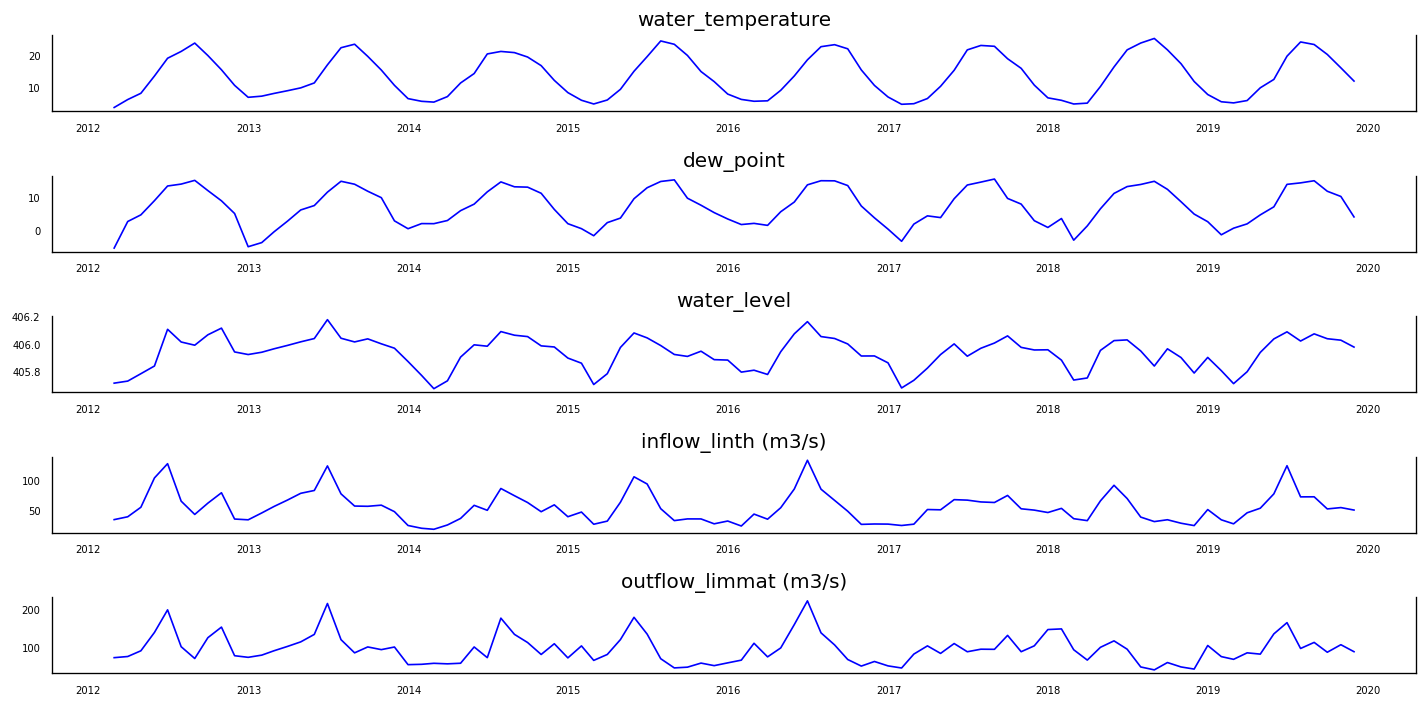

In [94]:
fig, axes = plt.subplots(nrows=5, ncols=1, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    data = dvar[dvar.columns[i]]
    ax.plot(data, color='blue', linewidth=1)
    # Decorations
    ax.set_title(dvar.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

As shown in the figure above, there is quite some seasonality.

Check for causality (Granger).

In [95]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    
    #The rows are the response variable, columns are predictors. The values in the table are the P-Values. P-Values lesser than the significance level (0.05), implies the Null Hypothesis that the coefficients of the corresponding past values is zero, that is, the X does not cause Y can be rejected.

    dvar = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in dvar.columns:
        for r in dvar.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            dvar.loc[r, c] = min_p_value
    dvar.columns = [var + '_x' for var in variables]
    dvar.index = [var + '_y' for var in variables]
    return dvar

grangers_causation_matrix(dvar, variables = dvar.columns) 

,water_temperature_x,dew_point_x,water_level_x,inflow_linth (m3/s)_x,outflow_limmat (m3/s)_x
water_temperature_y,1.0000,0.000,0.0002,0.0000,0.0000
dew_point_y,0.0000,1.000,0.0088,0.0000,0.0034
water_level_y,0.0000,0.000,1.0000,0.0024,0.0006
inflow_linth (m3/s)_y,0.0000,0.000,0.0008,1.0000,0.0070
outflow_limmat (m3/s)_y,0.0004,0.001,0.0196,0.0538,1.0000


The row are the Response (Y) and the columns are the predictor series (X).

Cointegration test.

In [96]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(dvar, alpha=0.05): 
    out = coint_johansen(dvar,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(dvar.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(dvar)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
water_temperature ::  134.15    > 60.0627   =>   True
dew_point ::  62.89     > 40.1749   =>   True
water_level ::  29.74     > 24.2761   =>   True
inflow_linth (m3/s) ::  9.32      > 12.3212   =>   False
outflow_limmat (m3/s) ::  0.26      > 4.1296    =>   False


Order of integration(d) is nothing but the number of differencing required to make a non-stationary time series stationary.

Now, when you have two or more time series, and there exists a linear combination of them that has an order of integration (d) less than that of the individual series, then the collection of series is said to be cointegrated.

Split the data

In [97]:
nobs = 11
dvar_train, dvar_test = dvar[0:-nobs], dvar[-nobs:]

print(dvar_train.shape)  
print(dvar_test.shape)

(83, 5)
(11, 5)


Stationarity.
For the VAR Model only stationary time series can be used. In order to verify it, we are going to use the ADF test.

In [98]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [99]:
for name, column in dvar_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "water_temperature" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.2015
 No. Lags Chosen       = 7
 Critical value 1%     = -3.521
 Critical value 5%     = -2.901
 Critical value 10%    = -2.588
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "dew_point" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.454
 No. Lags Chosen       = 7
 Critical value 1%     = -3.521
 Critical value 5%     = -2.901
 Critical value 10%    = -2.588
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "water_level" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Signi

C:\Users\lucal\AppData\Local\Temp\ipykernel_29312\1179845333.py:1: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in dvar_train.iteritems():


In [100]:
# difference the training data once
dvar_diff = dvar_train.diff().dropna()

c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


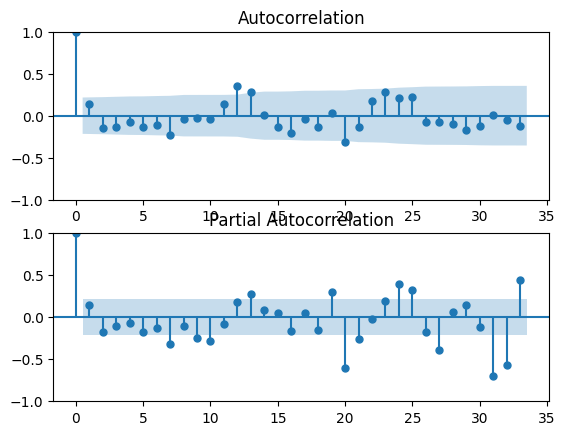

In [101]:
# plot autocorrelation and partial autocorrelation
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(dvar_diff["water_level"], lags=33, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(dvar_diff["water_level"], lags=33, ax=ax[1])
plt.show()


All except water level are stationary. We need to difference the variables and then check the ADF one more time.

Selection of the p order for the VAR.

In [102]:
model = VAR(dvar_diff)
for i in [1,2,3,4,5,6,7,8,9, 10, 11, 12]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  8.59265219527572
BIC :  9.479485215524772
FPE :  5399.229191918158
HQIC:  8.94846122396949 

Lag Order = 2
AIC :  8.350312110074462
BIC :  9.987955421412755
FPE :  4268.753399434566
HQIC:  9.00689017418778 

Lag Order = 3
AIC :  7.747471312905445
BIC :  10.146912176163188
FPE :  2382.4048156084464
HQIC:  8.708760733816515 

Lag Order = 4
AIC :  7.526004006263161
BIC :  10.698496657576072
FPE :  1986.3205282320553
HQIC:  8.796011087935275 

Lag Order = 5
AIC :  7.30750188456908
BIC :  11.264575973412962
FPE :  1711.9618720797878
HQIC:  8.890296757318973 

Lag Order = 6
AIC :  6.971313824987062
BIC :  11.724783137413134
FPE :  1370.8663346491521
HQIC:  8.87103008816256 

Lag Order = 7
AIC :  6.579147305105343
BIC :  12.141118777592487
FPE :  1106.5364282700082
HQIC:  8.799981439243547 

Lag Order = 8
AIC :  5.566031901515197
BIC :  11.948914929986207
FPE :  527.2180370173952
HQIC:  8.112242416632043 

Lag Order = 9
AIC :  4.973480683663496
BIC :  12.18999673111733
FP

c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Let's try lag 3.

Train the model with the lag 3.

In [165]:
model_fitted = model.fit(7)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 30, Nov, 2022
Time:                     12:14:43
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    12.1411
Nobs:                     75.0000    HQIC:                   8.79998
Log likelihood:          -598.820    FPE:                    1106.54
AIC:                      6.57915    Det(Omega_mle):         155.832
--------------------------------------------------------------------
Results for equation water_temperature
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                            0.052207         0.148754            0.351           0.726
L1.water_temperature             0.291558         0.201958            1.444           0.149
L1.d

Residuals with Durbin Watson Statistic

In [166]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(dvar.columns, out):
    print(col, ':', round(val, 2))

water_temperature : 2.05
dew_point : 1.82
water_level : 2.13
inflow_linth (m3/s) : 1.95
outflow_limmat (m3/s) : 2.09


CHECK THE MEANING

Forecasting

In [167]:
lag_order = model_fitted.k_ar
print(lag_order)  

# Input data for forecasting
forecast_input = dvar_diff.values[-lag_order:]
forecast_input

7


array([[ 5.29731382e+00,  2.10481956e+00,  5.15546940e-03,
        -2.26107918e+01, -2.20830295e+01],
       [ 2.11835005e+00,  6.47423747e-01, -8.02686424e-02,
        -3.16428295e+01, -4.71298388e+01],
       [ 1.42155132e+00,  9.68313684e-01, -1.09416903e-01,
        -7.67900680e+00, -7.76007388e+00],
       [-3.53176041e+00, -2.46303541e+00,  1.25027378e-01,
         3.13691781e+00,  1.94638517e+01],
       [-4.29771625e+00, -3.79397990e+00, -6.33206788e-02,
        -5.92968620e+00, -1.16677711e+01],
       [-5.51411960e+00, -3.77922256e+00, -1.12429776e-01,
        -4.03596599e+00, -5.65278649e+00],
       [-4.04307945e+00, -2.33567055e+00,  1.13277778e-01,
         2.73421560e+01,  6.25459294e+01]])

In [168]:
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
dvar_forecast = pd.DataFrame(fc, index=dvar.index[-nobs:], columns=dvar.columns)
dvar_forecast

,water_temperature,dew_point,water_level,inflow_linth (m3/s),outflow_limmat (m3/s)
datetime,,,,,
2019-01-31,1.431063,3.016774,0.036007,10.585181,6.209954
2019-02-28,1.461695,0.155719,-0.084941,-6.176248,11.039962
2019-03-31,2.473899,2.137344,-0.040609,-2.171383,-22.223066
2019-04-30,2.950866,2.221530,0.045806,-2.632434,-13.806224
2019-05-31,2.502201,2.858760,0.116909,13.181955,13.763181
2019-06-30,2.739726,1.825301,0.097856,21.841505,32.657644
2019-07-31,0.484532,-1.700670,-0.062806,-18.494153,-38.736589
2019-08-31,-1.135528,-0.761200,-0.041501,-10.083906,8.948131
2019-09-30,-2.000566,-0.594936,-0.052591,-12.042916,-18.615838


In [169]:
# function for inverting the differenced data
def invert_transformation(dvar_train, dvar_forecast, first_diff=False): 
    dvar_fc = dvar_forecast.copy()
    columns = dvar_train.columns
    for col in columns:        
        dvar_fc[col] = dvar_train[col].iloc[-1] + dvar_fc[col].cumsum()
    return dvar_fc

In [170]:
dvar_results = invert_transformation(dvar_train, dvar_forecast, first_diff=True)

In [171]:
dvar_results

,water_temperature,dew_point,water_level,inflow_linth (m3/s),outflow_limmat (m3/s)
datetime,,,,,
2019-01-31,9.215113,5.592447,405.937118,60.507460,109.898531
2019-02-28,10.676808,5.748166,405.852177,54.331212,120.938492
2019-03-31,13.150707,7.885510,405.811568,52.159828,98.715426
2019-04-30,16.101573,10.107040,405.857373,49.527394,84.909202
2019-05-31,18.603774,12.965800,405.974282,62.709349,98.672383
2019-06-30,21.343500,14.791102,406.072138,84.550854,131.330028
2019-07-31,21.828032,13.090432,406.009332,66.056701,92.593439
2019-08-31,20.692504,12.329231,405.967831,55.972795,101.541570
2019-09-30,18.691938,11.734295,405.915240,43.929879,82.925732


<AxesSubplot: xlabel='datetime'>

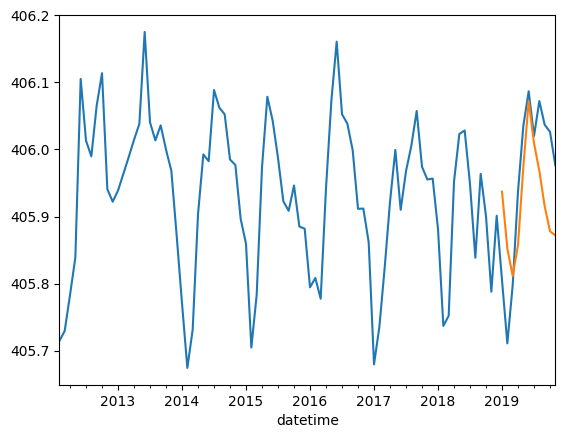

In [172]:
import matplotlib.pyplot as plt
dvar["water_level"].plot()
dvar_results["water_level"].plot()

In [173]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: water_level')
accuracy_prod = forecast_accuracy(dvar_results['water_level'].values, dvar_test['water_level'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast Accuracy of: water_level
mape :  0.0002
me :  -0.0325
mae :  0.0848
mpe :  -0.0001
rmse :  0.0985
corr :  0.6413
minmax :  0.0002


C:\Users\lucal\AppData\Local\Temp\ipykernel_29312\698907790.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\lucal\AppData\Local\Temp\ipykernel_29312\698907790.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


In [137]:
nobs 11 differenced
lags=10
mape :  0.0003
me :  -0.1297
mae :  0.1297
mpe :  -0.0003
rmse :  0.1449
corr :  0.859
minmax :  0.0003

lag=9
mape :  0.0003
me :  -0.139
mae :  0.139
mpe :  -0.0003
rmse :  0.1558
corr :  0.8261
minmax :  0.0003

lag=8
mape :  0.0004
me :  -0.1491
mae :  0.1491
mpe :  -0.0004
rmse :  0.1678
corr :  0.7723
minmax :  0.0004

lag=7
mape :  0.0002
me :  -0.0325
mae :  0.0848
mpe :  -0.0001
rmse :  0.0985
corr :  0.6413
minmax :  0.0002

lag=6
mape :  0.0002
me :  -0.0233
mae :  0.0711
mpe :  -0.0001
rmse :  0.0868
corr :  0.7256
minmax :  0.0002

lag=5
mape :  0.0002
me :  -0.0044
mae :  0.0694
mpe :  -0.0
rmse :  0.0769
corr :  0.7957
minmax :  0.0002

lag=4
mape :  0.0002
me :  -0.0309
mae :  0.0755
mpe :  -0.0001
rmse :  0.0861
corr :  0.795
minmax :  0.0002



SyntaxError: invalid syntax (2382138760.py, line 1)

In [ ]:
nobs 11 undifferenced

lags=10
mape :  0.0002
me :  -0.0469
mae :  0.0745
mpe :  -0.0001
rmse :  0.0852
corr :  0.9247
minmax :  0.0002

lag=9
mape :  0.0002
me :  -0.0461
mae :  0.0744
mpe :  -0.0001
rmse :  0.0874
corr :  0.9125
minmax :  0.0002

lag=8
mape :  0.0001
me :  -0.01
mae :  0.054
mpe :  -0.0
rmse :  0.0626
corr :  0.8621
minmax :  0.0001

lag=7
mape :  0.0001
me :  -0.0098
mae :  0.0553
mpe :  -0.0
rmse :  0.0616
corr :  0.8919
minmax :  0.0001

lag=6
mape :  0.0002
me :  -0.0295
mae :  0.0651
mpe :  -0.0001
rmse :  0.071
corr :  0.8684
minmax :  0.0002

lag=5
mape :  0.0001
me :  -0.0175
mae :  0.0558
mpe :  -0.0
rmse :  0.0601
corr :  0.9164
minmax :  0.0001

lag=4
mape :  0.0002
me :  -0.016
mae :  0.0635
mpe :  -0.0
rmse :  0.0683
corr :  0.8897
minmax :  0.0002

lag=3
mape :  0.0002
me :  -0.0119
mae :  0.0758
mpe :  -0.0
rmse :  0.0861
corr :  0.822
minmax :  0.0002